**Installing the library of kaggle to import the dataset**

In [ ]:
!pip install -q kaggle

**Uploading the token for kaggle use**

In [ ]:
from google.colab import files

# Allow user to upload a file
uploaded = files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d splcher/animefacedataset

In [ ]:
!unzip /content/animefacedataset.zip && rm /content/animefacedataset.zip

**Cloning the GitHub repo of Wasserstein GAN**

In [ ]:
!git clone https://github.com/martinarjovsky/WassersteinGAN.git

Cloning into 'WassersteinGAN'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 1.79 MiB | 11.24 MiB/s, done.
Resolving deltas: 100% (70/70), done.


**Main Command line for executing the training of WGAN**

In [ ]:
!python /content/WassersteinGAN/main.py --dataset folder --dataroot /content/test --cuda # Creating a folder which goes by the name "test" and then copy the extracted datset into it.

**Importing the Neccesary libraries and importing the generator class from the model**

In [ ]:
import torch
import torch.nn as nn
from torchvision.utils import save_image
from models.dcgan import DCGAN_G #once done with the training and the github repo cloned make sure to move the folder which goes by the name models out of the main WGAN folder.

**loading the weights and setting up the generator to the eval mode**

> The following weights of the generator are saved after training of the GAN model.



In [ ]:
generator = DCGAN_G(isize=64, nz=100, nc=3, ngf=64, ngpu=1)
generator_weights_path = '/content/netG_epoch_73.pth'# will be providedby me
generator.load_state_dict(torch.load(generator_weights_path, map_location=torch.device('cuda')))
generator.eval()

DCGAN_G(
  (main): Sequential(
    (initial:100-512:convt): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial:512:batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (initial:512:relu): ReLU(inplace=True)
    (pyramid:512-256:convt): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:256:batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:256:relu): ReLU(inplace=True)
    (pyramid:256-128:convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:128:relu): ReLU(inplace=True)
    (pyramid:128-64:convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:64:batchnorm): BatchNorm2d(64, eps=1e-05, m

**Instatntiating the CNN and setting up the encoder(CNN)**

> The main objective of the CNN is to produce a latent representaion of an image that can accurately reconstruct the input/query image which would further involve comparing the output of the CNN and the latent vector derived from the same image thereby calculating the loss succesively for each epoch.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class CustomConvNet(nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__()

        # Constraints for layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding="same")
        #self.batch1=nn.BatchNorm2d(16) #new batch layer
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding="same")
        #chnaged the out_channel from 16 to 32
        self.batch2 = nn.BatchNorm2d(32) #subsequent changes made over here
        self.relu2=nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Constraints for layer 2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same")#changing these from 32 to 64
        #self.batch3 = nn.BatchNorm2d(64) #new batch layer
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding="same")
        self.batch4 = nn.BatchNorm2d(128) #subsequent changes
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Adjusted Linear layer
        self.fc = nn.Linear(128 * 16 * 16, 100)  # Since the genrator takes in the input of noise vector of 100 channels likewise the output channels in the linear layer set to 100.

    # defining the network flow

    def forward(self, x):
        # Conv 1
        out = self.conv1(x)
        #out = self.batch1(out)
        out=self.relu1(out)
        out=self.conv2(out)
        out = self.batch2(out)
        out = self.relu2(out)

        # Max Pool 1
        out = self.pool1(out)

        # Conv 2
        out = self.conv3(out)
        #out = self.batch3(out)
        out = self.relu3(out)
        out=self.conv4(out)
        out = self.batch4(out)
        out = self.relu4(out)

        # Max Pool 2
        out = self.pool2(out)
        out = out.view(out.size(0), -1)

        # Linear Layer
        out = self.fc(out)

        return out.view(-1, 100, 1, 1)  # Reshaping it to our requirements since our generator accepts size of the vector as (1,  ,1,1)

encoder = CustomConvNet()


**Training the encoder and loss calculation**



In [ ]:
  # Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=1e-4)

# Training loop
params=generator.parameters()
for param in params:
 param.requires_grad = False
encoder.train()
num_epochs = 10000  # Adjust the number of epochs as needed
for epoch in range(num_epochs):

        latent_true = torch.randn(32,100,1,1)
        generated_image = generator(latent_true)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        latent_pred = encoder(generated_image)

        # Compute the loss
        loss = criterion(latent_pred, latent_true)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if epoch%100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

**Weight loading in the encoder and setting up into the eval mode**

In [ ]:
encoder_weights_path="/content/CNN2.pth"#I will be attaching the actual path file for the weights in the end eval report
encoder.load_state_dict(torch.load(encoder_weights_path, map_location=torch.device('cuda')))
encoder.eval()

CustomConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=32768, out_features=100, bias=True)
)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

***Importing the Anime images to be styled by the user ***


> For indication puurposes I have kept multiple images over here.(but depicting the transition pairwise over here)


> Please do have a look at the inline comments as well.





In [ ]:
from PIL import Image

# Load the image
image1 = Image.open('/content/10053_2004.jpg').convert('RGB')  #you can add any image of your choice to the collab and than paste the path over here
image2 = Image.open('/content/10000_2004.jpg').convert('RGB')
image3 = Image.open('/content/10133_2004.jpg').convert('RGB')
image4 = Image.open('/content/1001_2000.jpg').convert('RGB')
image5 = Image.open('/content/10020_2004.jpg').convert('RGB')
image6 = Image.open('/content/10029_2004.jpg').convert('RGB')
image7 = Image.open('/content/10032_2004.jpg').convert('RGB')
image8 = Image.open('/content/10104_2004.jpg').convert('RGB')


**Resizing the images as per the required size for the encoder**

In [ ]:
import torchvision.transforms as transforms

# Define the image transformations
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to the desired input size of the CNN
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [ ]:
image_paths = [#creating the image_paths list to store the address of each image
    '/content/10053_2004.jpg',
    '/content/10000_2004.jpg',
    '/content/10133_2004.jpg',  #I have taken 8 images over here and shown the images interpolating from one image to the other;if a person requires an image which contain the styles of both the images equally he can than sort of average out the linear vector
    '/content/1001_2000.jpg',
    '/content/10020_2004.jpg',
    '/content/10029_2004.jpg',
    '/content/10032_2004.jpg',
    '/content/10104_2004.jpg'
]

image_vectors=[]

In [ ]:
from PIL import Image
for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    latent_i = preprocess(image).unsqueeze(0)
    image_vectors.append(latent_i)#image vector contains the image in a pixel value format

In [ ]:
for i in range(0,8):##The following code line shows that the image are in accordance with the size to be fed into our encoder model
 print((image_vectors[i]).shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


**Viewing of the images uploaded by the user**

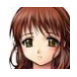

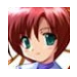

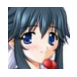

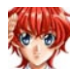

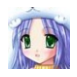

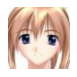

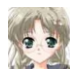

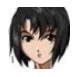

In [ ]:
import torchvision.utils as vutils
for i in range(0,8):
 grid = vutils.make_grid(image_vectors[i], nrow=1, padding=2, normalize=True)
 plt.figure(figsize=(1, 1), dpi=80)
 plt.imshow(grid.permute(1, 2, 0))  # Change the order of dimensions for matplotlib
 plt.axis('off')
 plt.show()

**Linearly interpolating between the images to create a style image**


> The latent vector of the image will be interpolated in the following cell.The image is interpolated between to a different target image and thus a transition is shown in the form of a gif.(If a person is intrested in an image which has the features/characterstics of both the image we can also try to average out the latent vector than pass it to the genrator for the image generation)


> In the later part of the code I have also presented all the reconstructed/ synthetic images which have been generated by the trained GAN.




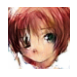

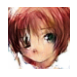

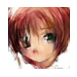

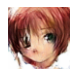

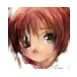

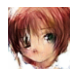

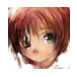

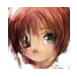

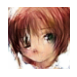

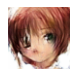

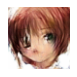

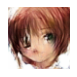

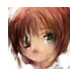

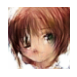

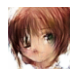

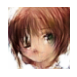

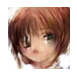

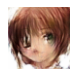

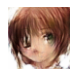

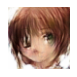

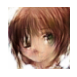

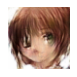

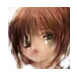

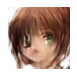

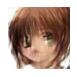

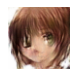

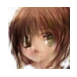

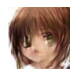

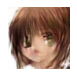

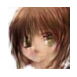

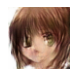

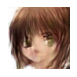

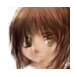

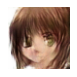

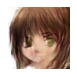

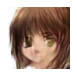

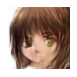

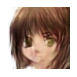

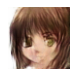

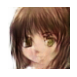

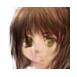

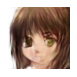

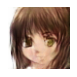

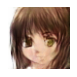

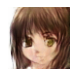

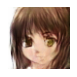

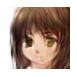

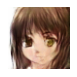

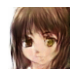

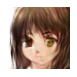

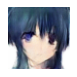

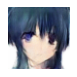

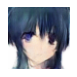

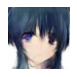

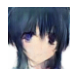

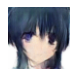

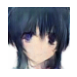

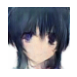

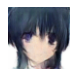

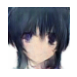

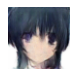

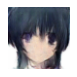

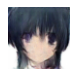

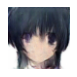

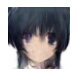

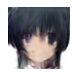

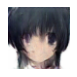

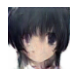

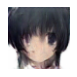

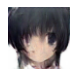

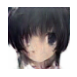

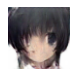

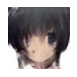

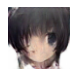

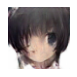

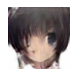

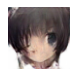

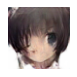

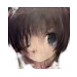

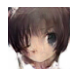

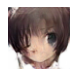

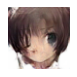

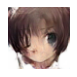

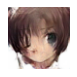

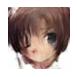

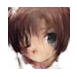

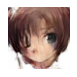

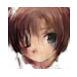

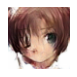

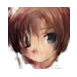

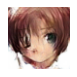

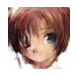

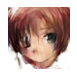

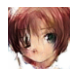

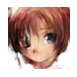

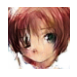

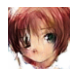

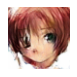

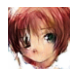

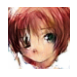

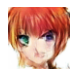

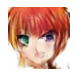

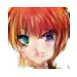

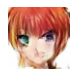

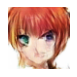

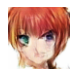

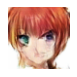

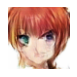

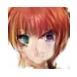

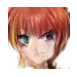

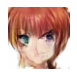

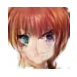

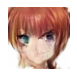

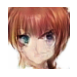

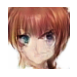

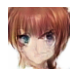

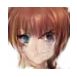

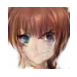

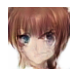

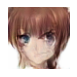

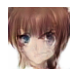

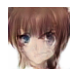

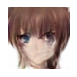

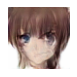

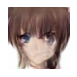

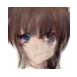

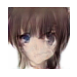

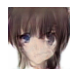

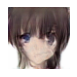

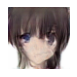

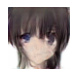

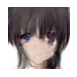

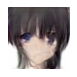

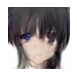

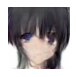

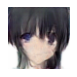

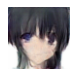

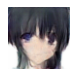

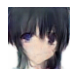

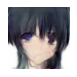

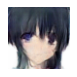

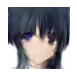

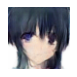

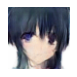

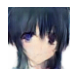

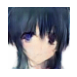

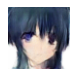

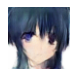

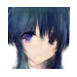

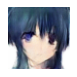

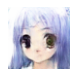

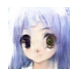

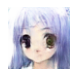

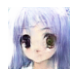

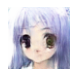

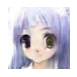

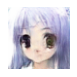

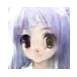

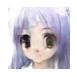

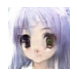

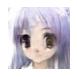

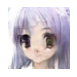

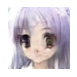

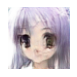

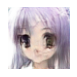

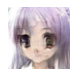

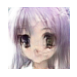

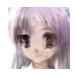

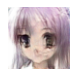

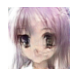

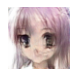

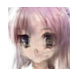

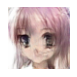

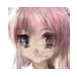

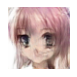

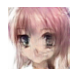

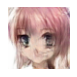

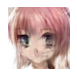

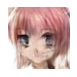

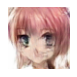

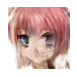

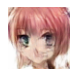

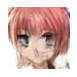

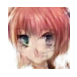

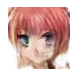

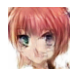

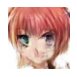

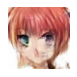

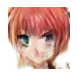

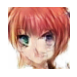

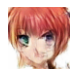

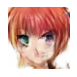

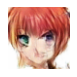

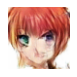

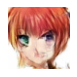

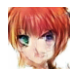

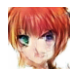

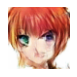

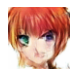

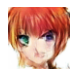

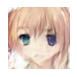

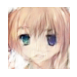

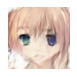

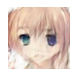

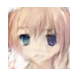

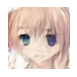

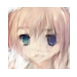

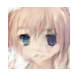

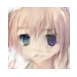

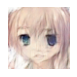

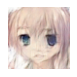

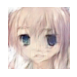

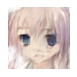

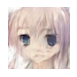

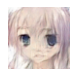

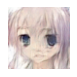

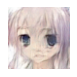

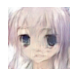

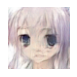

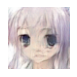

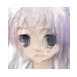

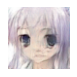

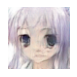

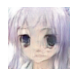

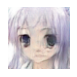

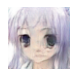

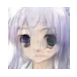

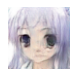

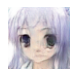

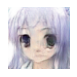

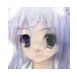

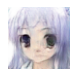

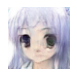

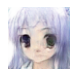

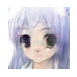

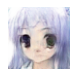

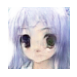

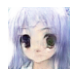

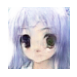

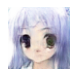

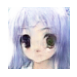

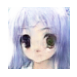

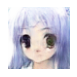

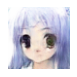

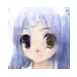

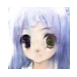

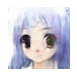

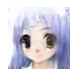

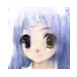

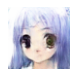

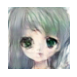

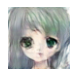

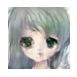

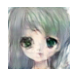

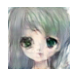

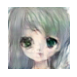

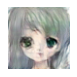

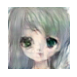

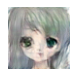

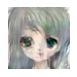

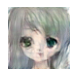

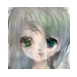

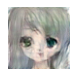

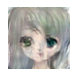

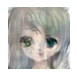

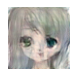

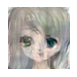

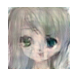

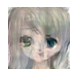

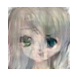

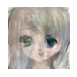

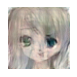

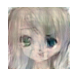

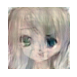

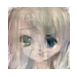

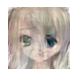

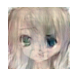

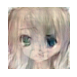

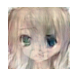

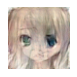

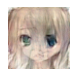

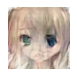

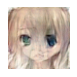

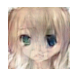

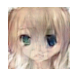

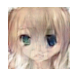

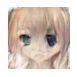

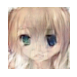

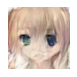

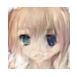

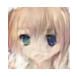

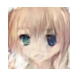

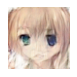

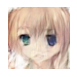

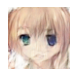

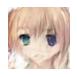

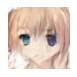

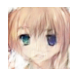

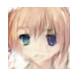

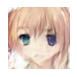

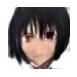

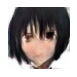

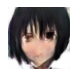

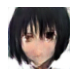

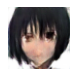

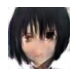

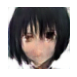

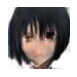

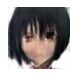

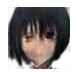

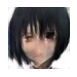

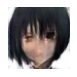

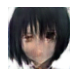

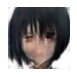

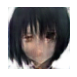

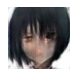

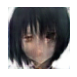

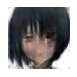

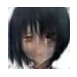

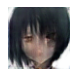

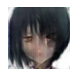

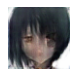

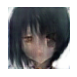

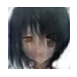

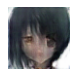

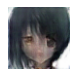

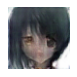

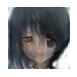

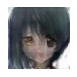

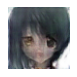

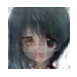

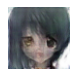

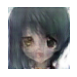

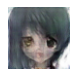

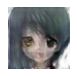

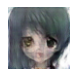

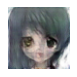

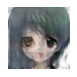

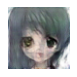

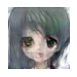

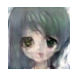

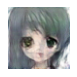

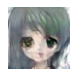

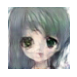

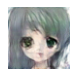

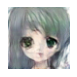

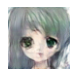

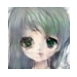

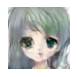

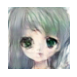

In [ ]:
num_interpolations = 50
import imageio  ## using the imageio library to create a gif image to depict the linear interpolating between two images
import os

for i in range(len(image_vectors) - 1):
    latent1 = encoder(image_vectors[i])
    latent2 = encoder(image_vectors[i + 1])
    alpha = torch.linspace(0, 1, num_interpolations)[:, None, None, None]
    interpolated_latents = alpha[:, None] * latent1 + (1 - alpha[:, None]) * latent2### Linear interpolation between two latent vectors.

    frames = []
    for j in range(num_interpolations):
        latent_vector = interpolated_latents[j]
        generated_image = generator(latent_vector)
        frame = vutils.make_grid(generated_image, nrow=1, padding=2, normalize=True)
        frame = frame.permute(1, 2, 0).detach().cpu().numpy()
        frames.append((frame * 255).astype('uint8'))
    output_gif_path = f"/content/morph/output_{i}.gif"
    imageio.mimsave(output_gif_path, frames, duration=0.1,loop=0)

    ###################################### Frame recronstructing and image frame interpolating into one another different reconstructed images
    for frame in frames:
     plt.figure(figsize=(1, 1),dpi=80)  # Adjust the size as needed
     plt.imshow(frame)
     plt.axis('off')
     plt.show()

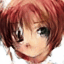

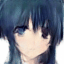

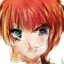

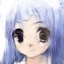

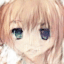

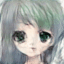

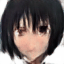

In [ ]:
from IPython.display import display, Image

for i in range(0,7):# make the changs in the range as per the imgaes you have entered in the array
 output_gif_path = f"/content/morph/output_{i}.gif"

 with open(output_gif_path, "rb") as f:
    display(Image(data=f.read()))
#In the first GIF we can see the first image slowly transitioning into the second image
#In the subsequent GIF we can see the second image slowly transitioning into the third image
#And So on

**Computing the MSE loss for Generator**

> Evaluating the MSE Loss for all the image vectors.



In [ ]:
for i in range(0,8):#
  latent_vectors=encoder(image_vectors[i])
  gen_image=generator(latent_vectors)
  mse_loss = nn.MSELoss()(gen_image, image_vectors[i])
  print(f'Mean Squared Error (MSE) between actual and generated images: {mse_loss.item()}')

**Evaluating the MSE error of Encoder model**

> Evaluating the MSE loss for about 10 iteration of the Encoder.




In [ ]:
for i in range(0,10):#suppose evaluating successively for about 10 different latent vectors to compute the MSE loss
 latent_vec=torch.randn(1,100,1,1)
 mse_l=nn.MSELoss()(latent_vec,encoder(generator(latent_vec)))
 print(f'Mean Squared Error (MSE) : {mse_l.item()}')

Mean Squared Error (MSE) : 0.44068947434425354
Mean Squared Error (MSE) : 0.3652368485927582
Mean Squared Error (MSE) : 0.4083988666534424
Mean Squared Error (MSE) : 0.2126571089029312
Mean Squared Error (MSE) : 0.44119030237197876
Mean Squared Error (MSE) : 0.39267203211784363
Mean Squared Error (MSE) : 0.33741819858551025
Mean Squared Error (MSE) : 0.3914884924888611
Mean Squared Error (MSE) : 0.31342944502830505
Mean Squared Error (MSE) : 0.320868581533432
